In [1]:
%matplotlib inline

# 592B, Class 13.1 (04/24). Spectral domain methods and representations III

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile 
import scipy.signal as signal
from scipy import fftpack

from ipywidgets import interactive
from IPython.display import Audio, display

## Review question
Explain why this code works as an implementation of a band pass filter.

In [51]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft

time   = np.linspace(0,10,2000) # define vector of sampled timepoints, 10 s, 200 Hz 
signal = np.cos(5*np.pi*time) + np.cos(6*np.pi*time) + np.cos(7*np.pi*time) # 2.5 Hz, 3.5 Hz

W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()


ind_band = [i for i in range(len(W)) if not (W[i] > 5 and W[i] < 6.5)]
cut_f_signal[ind_band] = 0
cut_signal = irfft(cut_f_signal)

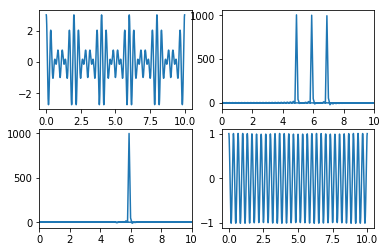

In [52]:
import pylab as plt
plt.subplot(221)
plt.plot(time,signal)
plt.subplot(222)
plt.plot(W,f_signal)
plt.xlim(0,10)
plt.subplot(223)
plt.plot(W,cut_f_signal)
plt.xlim(0,10)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.show()

## The cepstrum

For this section, we will be using [python_speech_features](https://github.com/jameslyons/python_speech_features) by [James Lyon](https://maxwell.ict.griffith.edu.au/spl/staff/j_lyons/home.htm). Install it using:

```
pip install python_speech_features
```
We can examine the code at the [github repository](https://github.com/jameslyons/python_speech_features) and via the [documentation](https://python-speech-features.readthedocs.io/en/latest/).

James Lyon also has some nice write-ups on the [cepstrum](http://www.practicalcryptography.com/miscellaneous/machine-learning/tutorial-cepstrum-and-lpccs/) and [MFCCs](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

In [56]:
import python_speech_features as sf

We'll also be working with the Hmong `mu` sound clip, `hmong_mu.wav`:

In [57]:
(rate,sig) = wavfile.read("hmong_mu.wav")
display(Audio(data=sig, rate=rate))

Let's first try out the example code to compute MFCCs on our data and see what happens. What are we computing?

In [61]:
mfcc_feat = sf.mfcc(sig,rate)
fbank_feat = sf.logfbank(sig,rate)

print(fbank_feat[1:3,:])

[[  9.48604681  11.26591526  13.28086417  12.1667777   10.64886722
    8.43059956   8.42281471  10.39944692  11.6743724   11.94109107
   10.94807454   8.60530954   9.22138677  10.1269899   10.71915785
   12.31164892  13.36692866  11.71759693  10.19334496  12.4500449
   13.0500245   11.69243803   9.28814623   8.0703234    7.8940491
    7.30392534]
 [  9.58582429  11.22931739  13.2541583   12.18804974  10.112898
    8.08288658   8.49332093  10.71504976  11.41107844  11.76862546
   10.79308621   7.96939038   9.01745726  10.11410139  10.54248624
   12.14758801  13.25845225  11.73166502  10.10545044  12.36890943
   13.01140214  11.75317593   9.20524085   7.93949196   7.75090327
    7.10381611]]


What we'll be doing now is working through the tutorials using the [github code repository code for `python_speech_features.base.mfcc`](https://python-speech-features.readthedocs.io/en/latest/). This function calls a ton of other sub-functions we'll need to understand in order to figure out how the computation is proceeding:

```python
def mfcc(signal,samplerate=16000,winlen=0.025,winstep=0.01,numcep=13,
         nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True,
         winfunc=lambda x:numpy.ones((x,))):
    """Compute MFCC features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the samplerate of the signal we are working with.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    feat = lifter(feat,ceplifter)
    if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy
    return feat
```

The basic steps are described in the tutorial [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/). Let's work through these. 

### Step 1. Frame the signal into short frames.

For this step, we'll need to understand `python_speech_features.sigproc.framesig`.

In [63]:
def framesig(sig, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames.
    :param sig: the audio signal to frame.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :param stride_trick: use stride trick to compute the rolling window and window multiplication faster
    :returns: an array of frames. Size is NUMFRAMES by frame_len.
    """
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step))

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = numpy.zeros((padlen - slen,))
    padsignal = numpy.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
            numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = numpy.array(indices, dtype=numpy.int32)
        frames = padsignal[indices]
        win = numpy.tile(winfunc(frame_len), (numframes, 1))

    return frames * win

### Step 2. For each frame calculate the periodogram estimate of the power spectrum.

For this step, we'll need to understand `python_speech_features.sigproc.powspec`.

### Step 3. Apply the mel filterbank to the power spectra, sum the energy in each filter.

For this step, we'll need to understand `python_speech_features.base.fbank`.

### Step 4. Take the logarithm of all filterbank energies.

For this step, we'll need to understand `python_speech_features.base.logfbank`.

### Step 5. Take the DCT of the log filterbank energies.

For this step, we'll need to take a look at `scipy.sig.fftpack.dct`.

### Step 6. Keep DCT coefficients 2-13, discard the rest.

For this step, we'll need to understand `python_speech_features.base.lifter`.